# Spectrum Extraction for MC LBDVELTF spectrometer 

## User parameters that must be input are in next cell.

In [1]:


#filepath_calib="C:/Users/tomfa/Desktop/DSP_spectrum_calibration-master/DSP_spectrum_calibration-master/"
filepath_calib="" # using github clone

#Command Path
filepath_stardata="star_data_raw"

#See TF_df dataframe below for relationship of TF catalog to other catalogs
TFnum='04'
#Exact File Name
filename="Capture_054.fit"

#Put files in directory TF"TFnum" in directory filepath_stardata or change the following file path to open
file_to_open=filepath_stardata+"/TF"+TFnum+"/"+filename 

output_folder="star_data_spectral"

### User choice!
#optional offset to move violet background near delta redward
#greater than 60 will overlap, which is bad.
#zero for consistency of delta with alpha, beta, gamma, positive to avoiding sampling missing data
ihv_offset_delta=0


Today's date: 2020-01-25
Header:
SIMPLE  =                    T                                                  
BITPIX  =                   16                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 2749                                                  
NAXIS2  =                  700                                                  
BZERO   =           32768.000000                                                
BSCALE  =             1.000000                                                  
DATAMIN =             0.000000                                                  
DATAMAX =           65535.000000                                                
INSTRUME=           'ATIK-460ex: fw rev 3.34'                                   
EXPTIME =           120.000                                                     
DATE-OBS=           '2019-11-13T03:25:48'                                   

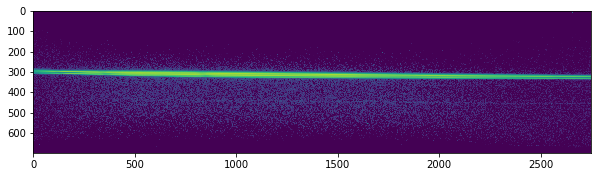

y_index of spectrum at x_index of 0 (i0) = 294.315
Verify that above number matches location of feature in image.
Verify that background is clear of star lines.
(Background is y = 500-600 if i0 < 400, 150-250 otherwise.)


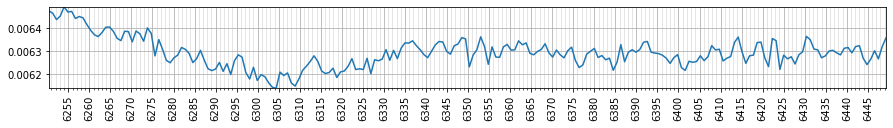

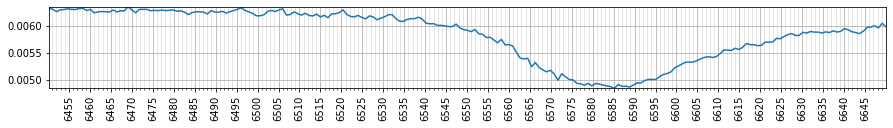

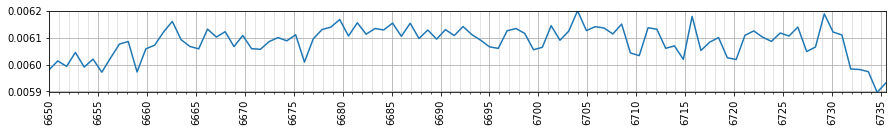

Find the location of the Hydrogen alpha feature in the three plots above.
Type this value into the next cell.


In [2]:
### import packages
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output,display,Math,Latex
import pandas as pd
from astropy.io import fits
from scipy import signal
from datetime import date
today = date.today()
print("Today's date:", today)
date_today=today.day+today.month*100+today.year*10000

### load argon calibration quartic coefficient matrices
k0=np.load(filepath_calib+"k0.npy")
k1=np.load(filepath_calib+"k1.npy")
k2=np.load(filepath_calib+"k2.npy")
k3=np.load(filepath_calib+"k3.npy")
k4=np.load(filepath_calib+"k4.npy")

TFdict=[{'num':0,'TF':'00','name':'','HD':0,'mag':0},
        {'num':1,'TF':'01','name':'gam Cas','HD':5394,'mag':2.39},
       {'num':2,'TF':'02','name':'BK Cam','HD':20336,'mag':4.85},
       {'num':3,'TF':'03','name':'6 Cep','HD':203467,'mag':5.18},
       {'num':4,'TF':'04','name':'HD 112028','HD':112028,'mag':5.35},
       {'num':5,'TF':'05','name':'HD 208682','HD':208682,'mag':5.86},
       {'num':6,'TF':'06','name':'HD 9612','HD':9612,'mag':6.57},
       {'num':7,'TF':'07','name':'FF Cam','HD':60062,'mag':7.90},
       {'num':8,'TF':'08','name':'HD 20566','HD':20566,'mag':7.94},
       {'num':9,'TF':'09','name':'HD 203024','HD':203024,'mag':8.86},
       {'num':10,'TF':'10','name':'EM* MWC 680','mag':9.41},
       {'num':11,'TF':'11','name':'EM* StHA 198','mag':10.54},
       {'num':12,'TF':'12','name':'EM* AS 518','mag':10.61},
       {'num':13,'TF':'13','name':'EM* GGR 192','mag':10.67}]

TF_df = pd.DataFrame(TFdict)

BeH_df= pd.DataFrame(columns=['star','date','clockreading','exptime','ccd-temp','date-proc','OK',
                              'Ans','Aunc','Adfe','Adft','Auncc',
                              'Bns','Bunc','Bdfe','Bdft','Buncc',
                              'Cns','Cunc','Cdfe','Cdft','Cuncc',
                              'Dns','Dunc','Ddfe','Ddft','Duncc','Doffset'])

#Star Name
starname=TF_df.loc[int(TFnum),'name']

### load raw data

hdulist = fits.open(file_to_open)  
print("Header:")
print(repr(hdulist[0].header))
print("")
scidata=hdulist[0].data

### Extract date and other info

dt=hdulist[0].header['DATE-OBS']
year=dt[0:4]
month=dt[5:7]
day=dt[8:10]
date=year+month+day
#print(date)
hr=dt[11:13]
minute=dt[14:16]
second=dt[17:19]
clockreading=hr+minute+second
#print(clockreading)

outfilename=output_folder+"/TF"+TFnum+"_"+date+"_"+clockreading
print("output to ",outfilename)

###Correct for exposure time
exptime=hdulist[0].header['EXPTIME'] 
img0=scidata/exptime #extract data per unit time
y0=hdulist[0].header['YORGSUBF']   #extract starting y line index from header
yoffset=200-y0 #default scans start at 200
img=img0[yoffset:,:]
###Correct for different y origin than default = 200


###Remove Bad Pixels###
import scipy.signal
img_sm = scipy.signal.medfilt(img, [1,3])
bad = (np.abs(img - img_sm) / 100) > .05
img_cr = img.copy()
img_cr[bad] = img_sm[bad]
ymin=0
ymax=800
ind2=np.argmax(img_cr[ymin:ymax,:],0)+ymin
print("Bad Pixels =", sum(sum(bad)),"(Should be roughly 1000)")

###Find indc "line" of Spectrum###
pix=np.arange(0,hdulist[0].header['NAXIS1'],1)
lines=np.arange(0,hdulist[0].header['NAXIS2']-yoffset,1)
m=.0108 
i2500=np.mean(ind2[2400:2600])
print("y_index of spectrum at x_index of 2500 =", i2500)
print("ccd pixel offset of y origin =",y0)
b=i2500-m*2500
indc=m*pix+b
i0=indc[0]

###Weighted Average of Nearby Lines###
y=lines
indca, ya = np.meshgrid(indc, lines,indexing='xy')
#print(indca.shape)
sigma=5
w=1/(np.sqrt(2*np.pi)*sigma)*np.e**(-(ya-indca)**2/(2*sigma**2))

###Generate Spectrum by weighted average###
sd= np.sum(w*img_cr,0)

### find average signal in non-spectrum part of slit
### compute background average and subtract off of spectrum
if i0>400:
    ybgs=200
else:
    ybgs=550

print(ybgs)
###Generate spectrum in background area (around 550 or 200)
#bg is not as smart as bg2
#bg=np.mean(img_cr[ybgs-50:ybgs+50,:],0)
b2=ybgs-m*2500
indc2=m*pix+b2
indca2, ya2 = np.meshgrid(indc2, lines,indexing='xy')
sigma2=40
w2=1/(np.sqrt(2*np.pi)*sigma2)*np.e**(-(ya2-indca2)**2/(2*sigma2**2))
bg2= np.sum(w2*img_cr,0)
sdbgs=sd-bg2

#Show background subtracted field
imgbgs=img-1.0*bg2
#plt.plot(imgbgs)
imgbgs[imgbgs<0]=0

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log((imgbgs+.5)**0.1))
plt.show()
print("y_index of spectrum at x_index of 0 (i0) =",i0)
print("Verify that above number matches location of feature in image.")
print("Verify that background is clear of star lines.")
print("(Background is y = 500-600 if i0 < 400, 150-250 otherwise.)")
###Start wavelength calibration assuming xs is zero
alphaPixel=2557
# find index used for this camera line (i2500woffset) in k matrix
i2500woffset=i2500+y0
lineindex=int(np.round(i2500woffset/10))

### To use this, you need to extract values of:
### li2500: the line of spectrum,
### pixfeature: the pixel of the feature
### and wlfeature: the wavelength of the feature 
### From data
### index 0 changes depending on the y range that we used in capture
li2500=lineindex-26  #260 is index 0, they are spaced by 10 ypixels
#60 is index 0 if we use only the size of the slit I think. Use 6 as subtracted #
#wlfeature=5183.6  pixpk=1109 #Mg from NIST database
wlfeature=6563
#this is wl of Halpha
pixpk=alphaPixel
#pixel (2557) where Halpha is if xse = 0

#first fit (cubicly) xs vs wl at this i2500 and xs
wl=np.polyval((k4[li2500],k3[li2500],k2[li2500],k1[li2500],k0[li2500]),pixpk)
xs=np.arange(-6,7,2)
lfit=np.polyfit(wl,xs,3)

#extract value of xs corresponding to actual wavelength that index found represents
xse=np.polyval(lfit,wlfeature)

# linear interpolation
from scipy.interpolate import interp1d
f=interp1d(xs,(k4[li2500,:],k3[li2500,:],k2[li2500,:],k1[li2500,:],k0[li2500,:]),fill_value="extrapolate")
#print(f(xse))
#linearly interpolated coefficients of quartic wl vs pixel fit

#wle should hold the calibrated wavelengths inferred from the interpolated coefficients 
#that match the value of xs inferred from matching pixpk and wlfeature 
pix=np.arange(0,2749)
wle=np.polyval(f(xse),pix)
f2=interp1d(wle,pix)

###Load transfer function
transfuncM=np.load(filepath_calib+"transfuncM.npy")

# linear interpolation into wavelengths used in MILES database
wlMILES=3500+0.9*np.arange(4367)

#extend data with zeros above and below
wlmin=wle[0];
wlmax=wle[-1];
wlE=np.insert(wle,0,wlmin);
wlE=np.insert(wlE,0,0);
wlE=np.append(wlE,wlmax);
wlE=np.append(wlE,1000000);

y = np.insert(sdbgs,0,0);
y = np.insert(y,0,0);
y = np.append(y,0);
y = np.append(y,0);

f = interp1d(wlE, y)
spM=f(wlMILES)

###siM is now normalized, transferred, but not wavelength(xs) calibrated 
siM=spM/transfuncM

fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(15, 1.5))
xmin=6250
xmax=6450
major_ticks = np.arange(xmin,xmax, 5)
minor_ticks = np.arange(xmin,xmax, 1)
mask = (wlMILES >= xmin) & (wlMILES <= xmax)
ax1.plot(wlMILES[mask],siM[mask])
ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)
ax1.grid(which='both')
ax1.grid(which='minor', alpha=0.4)
ax1.grid(which='major', alpha=1)
ax1.tick_params(axis='x',labelrotation=90)
ax1.autoscale(axis='both',tight=True)

fig, ax2 = plt.subplots(nrows=1, ncols=1,figsize=(15, 1.5))
xmin=6450
xmax=6650
major_ticks = np.arange(xmin,xmax, 5)
minor_ticks = np.arange(xmin,xmax, 1)
mask = (wlMILES >= xmin) & (wlMILES <= xmax)
ax2.plot(wlMILES[mask],siM[mask])
ax2.set_xticks(major_ticks)
ax2.set_xticks(minor_ticks, minor=True)
ax2.grid(which='both')
ax2.grid(which='minor', alpha=0.4)
ax2.grid(which='major', alpha=1)
ax2.tick_params(axis='x',labelrotation=90)
ax2.autoscale(axis='both',tight=True)

fig, ax3 = plt.subplots(nrows=1, ncols=1,figsize=(15, 1.5))
xmin=6650
xmax=6850
major_ticks = np.arange(xmin,xmax, 5)
minor_ticks = np.arange(xmin,xmax, 1)
mask = (wlMILES >= xmin) & (wlMILES <= xmax)
tempy=siM[mask]
tempy[tempy==0]=['nan']
ax3.plot(wlMILES[mask],tempy)
ax3.set_xticks(major_ticks)
ax3.set_xticks(minor_ticks, minor=True)
ax3.grid(which='both')
ax3.grid(which='minor', alpha=0.4)
ax3.grid(which='major', alpha=1)
ax3.tick_params(axis='x',labelrotation=90)
ax3.autoscale(axis='both',tight=True)

plt.show()

print("Find the location of the Hydrogen alpha feature in the three plots above.")
print("Type this value into the next cell.")

In [3]:
### User measured location of Hydrogen alpha feature to calibrate wavelength INPUT BELOW
alphacenter=6584

pixel of H-alpha = 2580


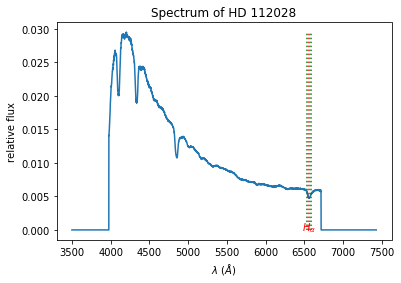

Hydrogen lines: 6563.6 4861.7 4340.6 4102.1
MILES indices of hydrogen lines: (3404, 1513, 934, 669)


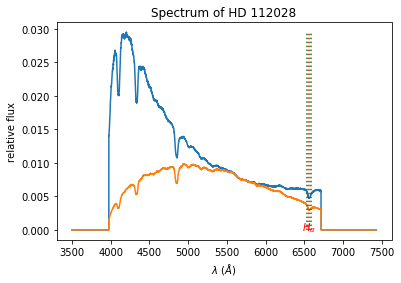

wavelength = 6563.6 , normalized signal = 0.834965536635729


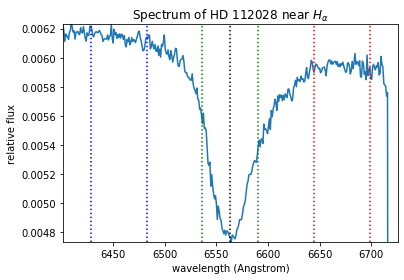

wavelength = 4861.7 , normalized signal = 0.8047781805134597


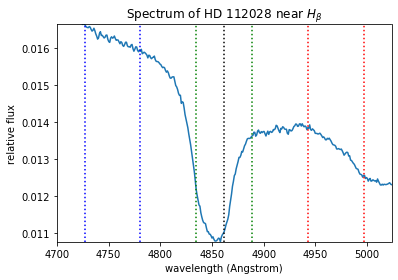

wavelength = 4340.6 , normalized signal = 0.80825042848486


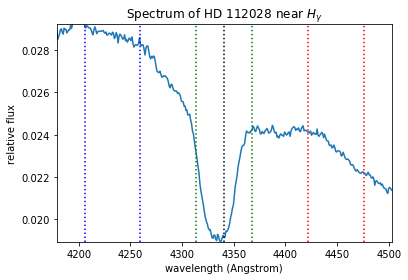

wavelength = 4102.1 , normalized signal = 1.0116226510652429


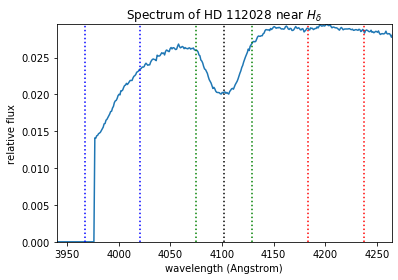

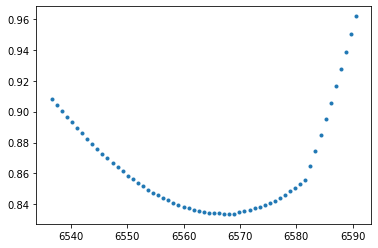

Should have an extremum near the center showing wavelength calibration OK


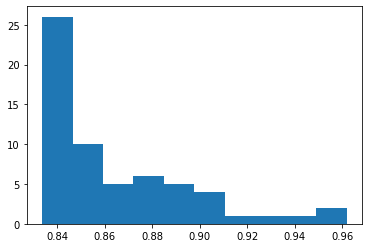

Deviations (extrumum,tail): 0.0012355238254253553 -0.12686683934591658


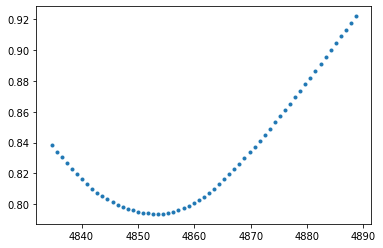

Should have an extremum near the center showing wavelength calibration OK


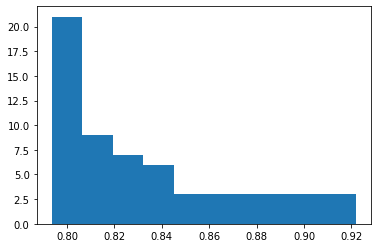

Deviations (extrumum,tail): 0.01114681063442069 -0.11724809488244337


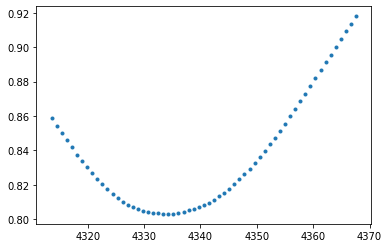

Should have an extremum near the center showing wavelength calibration OK


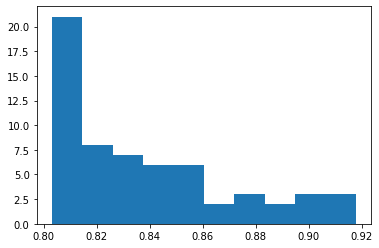

Deviations (extrumum,tail): 0.005136056774756037 -0.10973106974212143


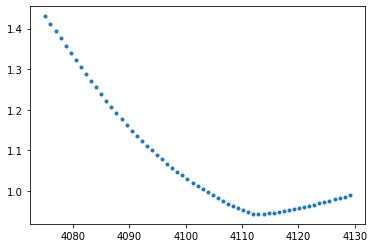

Should have an extremum near the center showing wavelength calibration OK


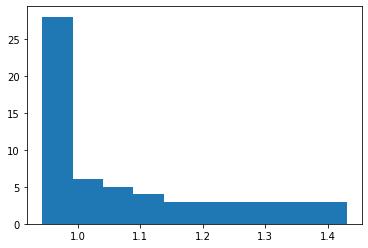

Deviations (extrumum,tail): 0.06872915921163791 -0.4188191382985684


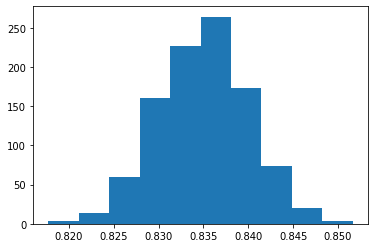

uncertainty =  0.005123792785198646


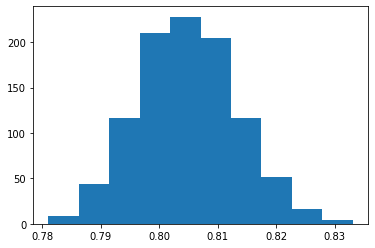

uncertainty =  0.008417355549063494


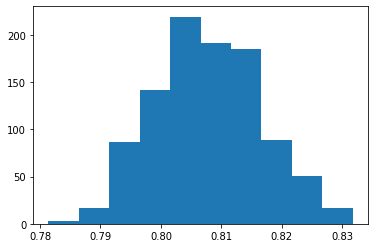

uncertainty =  0.008859791239997005


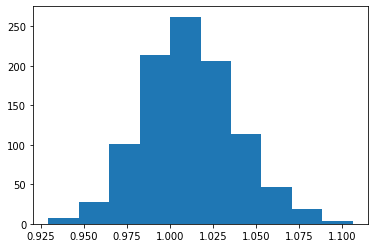

uncertainty =  0.027207572170960533


,ns,unc,dfe,dft,uncc
a,0.834966,0.00512379,0.00123552,-0.126867,0.006359
b,0.804778,0.00841736,0.0111468,-0.117248,0.019564
c,0.80825,0.00885979,0.00513606,-0.109731,0.013996
d,1.01162,0.0272076,0.0687292,-0.418819,0.095937


,star,date,clockreading,exptime,ccd-temp,date-proc,OK,Ans,Aunc,Adfe,...,Cunc,Cdfe,Cdft,Cuncc,Dns,Dunc,Ddfe,Ddft,Duncc,Doffset
0,HD 112028,20191113,032548,120,-4.6,20200125,?,0.834966,0.00512379,0.00123552,...,0.00885979,0.00513606,-0.109731,0.0139958,1.01162,0.0272076,0.0687292,-0.418819,0.0959367,0


In [4]:
f2=interp1d(wle,pix)
alphaPixel=int(np.round(f2(alphacenter))) 
print("pixel of H-alpha =",alphaPixel)

wlfeature=6563
#this is wl of Halpha
pixpk=alphaPixel
#pixel where min or max is found in feature
# find index used for this camera line (i2500woffset) in k matrix
#i2500woffset=i2500+y0
#lineindex=int(np.round(i2500woffset/10))

### To use this, you need to extract values of:
### li2500: the line of spectrum,
### pixfeature: the pixel of the feature
### and wlfeature: the wavelength of the feature 
### From data
### index 0 changes depending on the y range that we used in capture
#li2500=lineindex-26  #260 is index 0, they are spaced by 10 ypixels
#60 is index 0 if we use only the size of the slit I think. Use 6 as subtracted #
#wlfeature=5183.6  pixpk=1109 #Mg from NIST database

#first fit (cubicly) xs vs wl at this i2500 and xs
wl=np.polyval((k4[li2500],k3[li2500],k2[li2500],k1[li2500],k0[li2500]),pixpk)
xs=np.arange(-6,7,2)
lfit=np.polyfit(wl,xs,3)

#extract value of xs corresponding to actual wavelength that index found represents
xse=np.polyval(lfit,wlfeature)

# linear interpolation
from scipy.interpolate import interp1d
f=interp1d(xs,(k4[li2500,:],k3[li2500,:],k2[li2500,:],k1[li2500,:],k0[li2500,:]),fill_value="extrapolate")
#print(f(xse))
#linearly interpolated coefficients of quartic wl vs pixel fit

#wle should hold the calibrated wavelengths inferred from the interpolated coefficients 
#that match the value of xs inferred from matching pixpk and wlfeature 
pix=np.arange(0,2749)
wle=np.polyval(f(xse),pix)
f2=interp1d(wle,pix)

###Load transfer function
transfuncM=np.load(filepath_calib+"transfuncM.npy")

# linear interpolation into wavelengths used in MILES database
wlMILES=3500+0.9*np.arange(4367)

#extend data with zeros above and below
wlmin=wle[0];
wlmax=wle[-1];
wlE=np.insert(wle,0,wlmin);
wlE=np.insert(wlE,0,0);
wlE=np.append(wlE,wlmax);
wlE=np.append(wlE,1000000);

y = np.insert(sdbgs,0,0);
y = np.insert(y,0,0);
y = np.append(y,0);
y = np.append(y,0);

f = interp1d(wlE, y)
spM=f(wlMILES)

###This is final spectrum
siM=spM/transfuncM
maxy=max(siM)

###plot final spectrum
plt.plot(wlMILES,siM)
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname)
halpha =  6563
plt.plot((halpha, halpha), (-0.00, maxy), ":r")
plt.plot((6535.7,6535.7), (-0.00, maxy), ":g")
plt.plot((wlMILES[3433],wlMILES[3433]), (-0.00, maxy), ":g")
plt.text(halpha, 0, r"$H_\alpha$", color="red", horizontalalignment="center");
plt.savefig(outfilename+"_spec.svg")
plt.savefig(outfilename+"_spec.pdf")
plt.savefig(outfilename+"_spec.png")
plt.show()

### Parameters for uncertainty sampling
ntrials=1000
nsample=60

### finding index for each Hydrogen line 
###(was done manually until they are the nearest WL below the Hydrogen line)
print("Hydrogen lines:",wlMILES[3404],wlMILES[1513],wlMILES[934],wlMILES[669])
mi=(3404,1513,934,669)
print("MILES indices of hydrogen lines:",mi)

###plot spectrum w/ & w/o transfer function
plt.plot(wlMILES,siM)
plt.plot(wlMILES,spM/max(transfuncM))
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname)
halpha =  6563
plt.plot((halpha, halpha), (-0.00, maxy), ":r")
plt.plot((6535.7,6535.7), (-0.00, maxy), ":g")
plt.plot((wlMILES[3433],wlMILES[3433]), (-0.00, maxy), ":g")
plt.text(halpha, 0, r"$H_\alpha$", color="red", horizontalalignment="center");
plt.show()

###Make a dataframe to store data concerning Hydrogen lines
Hl_df= pd.DataFrame(columns=['ns','unc','dfe','dft'])

### Plot H-alpha
### ih is central index, v mean continuum below, r means continuum above 
### b,t are lower and upper limits of each band
halfwidth=30
centerseparation=120

ih=mi[0]
ihb=ih-halfwidth
iht=ih+halfwidth
ihvb=ih-halfwidth-centerseparation
ihvt=ih-centerseparation+halfwidth
ihrb=ih+centerseparation-halfwidth
ihrt=ih+centerseparation+halfwidth

s=np.mean(siM[ihb:iht])
sv=np.mean(siM[ihvb:ihvt])
sr=np.mean(siM[ihrb:ihrt])

normsigh=2*s/(sv+sr)
print("wavelength =",wlMILES[ih],", normalized signal =",normsigh)

ybottom=min(siM[ihvb:ihrt])
ytop=max(siM[ihvb:ihrt])
plt.plot(wlMILES,siM)
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname+r" near $H_\alpha$")
plt.plot((wlMILES[ih], wlMILES[ih]), (ybottom,ytop), ":k")
plt.plot((wlMILES[ihvt],wlMILES[ihvt]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihvb],wlMILES[ihvb]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihrt],wlMILES[ihrt]), (ybottom,ytop), ":r")
plt.plot((wlMILES[ihrb],wlMILES[ihrb]), (ybottom,ytop), ":r")
plt.plot((wlMILES[iht],wlMILES[iht]), (ybottom,ytop), ":g")
plt.plot((wlMILES[ihb],wlMILES[ihb]), (ybottom,ytop), ":g")
plt.xlim((wlMILES[ihvb-30],wlMILES[ihrt+30]))
plt.ylim((min(siM[ihvb:ihrt]),max(siM[ihvb:ihrt])))
plt.savefig(outfilename+"_Ha.svg")
plt.savefig(outfilename+"_Ha.pdf")
plt.savefig(outfilename+"_Ha.png")
plt.show()
Hl_df.loc['a','ns']=normsigh
normsighaprime=s/(sv)

###Plot H-beta
ih=mi[1]
ihb=ih-halfwidth
iht=ih+halfwidth
ihvb=ih-halfwidth-centerseparation
ihvt=ih-centerseparation+halfwidth
ihrb=ih+centerseparation-halfwidth
ihrt=ih+centerseparation+halfwidth
s=np.mean(siM[ihb:iht])
sv=np.mean(siM[ihvb:ihvt])
sr=np.mean(siM[ihrb:ihrt])
normsigh=2*s/(sv+sr)
print("wavelength =",wlMILES[ih],", normalized signal =",normsigh)
ybottom=min(siM[ihvb:ihrt])
ytop=max(siM[ihvb:ihrt])

plt.plot(wlMILES,siM)
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname+r" near $H_\beta$")

plt.plot((wlMILES[ih], wlMILES[ih]), (ybottom,ytop), ":k")
plt.plot((wlMILES[ihvt],wlMILES[ihvt]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihvb],wlMILES[ihvb]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihrt],wlMILES[ihrt]), (ybottom,ytop), ":r")
plt.plot((wlMILES[ihrb],wlMILES[ihrb]), (ybottom,ytop), ":r")
plt.plot((wlMILES[iht],wlMILES[iht]), (ybottom,ytop), ":g")
plt.plot((wlMILES[ihb],wlMILES[ihb]), (ybottom,ytop), ":g")

plt.xlim((wlMILES[ihvb-30],wlMILES[ihrt+30]))
plt.ylim((min(siM[ihvb:ihrt]),max(siM[ihvb:ihrt])))
plt.savefig(outfilename+"_Hb.svg")
plt.savefig(outfilename+"_Hb.pdf")
plt.savefig(outfilename+"_Hb.png")
plt.show()
Hl_df.loc['b','ns']=normsigh

###Plot H-gamma
ih=mi[2]
ihb=ih-halfwidth
iht=ih+halfwidth
ihvb=ih-halfwidth-centerseparation
ihvt=ih-centerseparation+halfwidth
ihrb=ih+centerseparation-halfwidth
ihrt=ih+centerseparation+halfwidth
s=np.mean(siM[ihb:iht])
sv=np.mean(siM[ihvb:ihvt])
sr=np.mean(siM[ihrb:ihrt])
normsigh=2*s/(sv+sr)
print("wavelength =",wlMILES[ih],", normalized signal =",normsigh)
ybottom=min(siM[ihvb:ihrt])
ytop=max(siM[ihvb:ihrt])

plt.plot(wlMILES,siM)
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname+r" near $H_\gamma$")

plt.plot((wlMILES[ih], wlMILES[ih]), (ybottom,ytop), ":k")
plt.plot((wlMILES[ihvt],wlMILES[ihvt]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihvb],wlMILES[ihvb]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihrt],wlMILES[ihrt]), (ybottom,ytop), ":r")
plt.plot((wlMILES[ihrb],wlMILES[ihrb]), (ybottom,ytop), ":r")
plt.plot((wlMILES[iht],wlMILES[iht]), (ybottom,ytop), ":g")
plt.plot((wlMILES[ihb],wlMILES[ihb]), (ybottom,ytop), ":g")

plt.xlim((wlMILES[ihvb-30],wlMILES[ihrt+30]))
plt.ylim((min(siM[ihvb:ihrt]),max(siM[ihvb:ihrt])))
plt.savefig(outfilename+"_Hc.svg")
plt.savefig(outfilename+"_Hc.pdf")
plt.savefig(outfilename+"_Hc.png")
plt.show()
Hl_df.loc['c','ns']=normsigh

###Plot H-delta
ih=mi[3]

ihb=ih-halfwidth
iht=ih+halfwidth
ihvb=ih-halfwidth-centerseparation+ihv_offset_delta
ihvt=ih-centerseparation+halfwidth+ihv_offset_delta
ihrb=ih+centerseparation-halfwidth
ihrt=ih+centerseparation+halfwidth
s=np.mean(siM[ihb:iht])
sv=np.mean(siM[ihvb:ihvt])
sr=np.mean(siM[ihrb:ihrt])
normsigh=2*s/(sv+sr)
print("wavelength =",wlMILES[ih],", normalized signal =",normsigh)
ybottom=min(siM[ihvb:ihrt])
ytop=max(siM[ihvb:ihrt])

plt.plot(wlMILES,siM)
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname+r" near $H_\delta$")

plt.plot((wlMILES[ih], wlMILES[ih]), (ybottom,ytop), ":k")
plt.plot((wlMILES[ihvt],wlMILES[ihvt]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihvb],wlMILES[ihvb]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihrt],wlMILES[ihrt]), (ybottom,ytop), ":r")
plt.plot((wlMILES[ihrb],wlMILES[ihrb]), (ybottom,ytop), ":r")
plt.plot((wlMILES[iht],wlMILES[iht]), (ybottom,ytop), ":g")
plt.plot((wlMILES[ihb],wlMILES[ihb]), (ybottom,ytop), ":g")

plt.xlim((wlMILES[ihvb-30],wlMILES[ihrt+30]))
plt.ylim((min(siM[ihvb:ihrt]),max(siM[ihvb:ihrt])))
plt.savefig(outfilename+"_Hd.svg")
plt.savefig(outfilename+"_Hd.pdf")
plt.savefig(outfilename+"_Hd.png")
plt.show()
Hl_df.loc['d','ns']=normsigh

### H alpha systematic error from wavelength error or uncertainty
ih0=mi[0]
index_width=30
ia=np.arange(index_width*2+1)
nsa=0.0*ia
wls=0.0*ia
for i in ia:
    ih=ih0-index_width+i
    ihb=ih-halfwidth
    iht=ih+halfwidth
    ihvb=ih-halfwidth-centerseparation
    ihvt=ih-centerseparation+halfwidth
    ihrb=ih+centerseparation-halfwidth
    ihrt=ih+centerseparation+halfwidth
    s=np.mean(siM[ihb:iht])
    sv=np.mean(siM[ihvb:ihvt])
    sr=np.mean(siM[ihrb:ihrt])
    nsa[i]=2*s/(sv+sr)
    wls[i]=wlMILES[ih]
plt.plot(wls,nsa,'.')
plt.show()
print("Should have an extremum near the center showing wavelength calibration OK")
plt.hist(nsa)
plt.show()
if scipy.stats.skew(nsa)>0:
    dev_from_extremum=nsa[index_width]-np.min(nsa)
    dev_from_tail=nsa[index_width]-np.max(nsa)
else:
    dev_from_extremum=nsa[index_width]-np.max(nsa)
    dev_from_tail=nsa[index_width]-np.min(nsa)
print("Deviations (extrumum,tail):",dev_from_extremum,dev_from_tail)
Hl_df.loc['a','dfe']=dev_from_extremum
Hl_df.loc['a','dft']=dev_from_tail

### H beta systematic error from wavelength error or uncertainty
ih0=mi[1]
index_width=30
ia=np.arange(index_width*2+1)
nsa=0.0*ia
wls=0.0*ia
for i in ia:
    ih=ih0-index_width+i
    ihb=ih-halfwidth
    iht=ih+halfwidth
    ihvb=ih-halfwidth-centerseparation
    ihvt=ih-centerseparation+halfwidth
    ihrb=ih+centerseparation-halfwidth
    ihrt=ih+centerseparation+halfwidth
    s=np.mean(siM[ihb:iht])
    sv=np.mean(siM[ihvb:ihvt])
    sr=np.mean(siM[ihrb:ihrt])
    nsa[i]=2*s/(sv+sr)
    wls[i]=wlMILES[ih]
plt.plot(wls,nsa,'.')
plt.show()
print("Should have an extremum near the center showing wavelength calibration OK")
plt.hist(nsa)
plt.show()
if scipy.stats.skew(nsa)>0:
    dev_from_extremum=nsa[index_width]-np.min(nsa)
    dev_from_tail=nsa[index_width]-np.max(nsa)
else:
    dev_from_extremum=nsa[index_width]-np.max(nsa)
    dev_from_tail=nsa[index_width]-np.min(nsa)
print("Deviations (extrumum,tail):",dev_from_extremum,dev_from_tail)
Hl_df.loc['b','dfe']=dev_from_extremum
Hl_df.loc['b','dft']=dev_from_tail

### H gamma systematic error from wavelength error or uncertainty
ih0=mi[2]
index_width=30
ia=np.arange(index_width*2+1)
nsa=0.0*ia
wls=0.0*ia
for i in ia:
    ih=ih0-index_width+i
    ihb=ih-halfwidth
    iht=ih+halfwidth
    ihvb=ih-halfwidth-centerseparation
    ihvt=ih-centerseparation+halfwidth
    ihrb=ih+centerseparation-halfwidth
    ihrt=ih+centerseparation+halfwidth
    s=np.mean(siM[ihb:iht])
    sv=np.mean(siM[ihvb:ihvt])
    sr=np.mean(siM[ihrb:ihrt])
    nsa[i]=2*s/(sv+sr)
    wls[i]=wlMILES[ih]
plt.plot(wls,nsa,'.')
plt.show()
print("Should have an extremum near the center showing wavelength calibration OK")
plt.hist(nsa)
plt.show()
if scipy.stats.skew(nsa)>0:
    dev_from_extremum=nsa[index_width]-np.min(nsa)
    dev_from_tail=nsa[index_width]-np.max(nsa)
else:
    dev_from_extremum=nsa[index_width]-np.max(nsa)
    dev_from_tail=nsa[index_width]-np.min(nsa)
print("Deviations (extrumum,tail):",dev_from_extremum,dev_from_tail)
Hl_df.loc['c','dfe']=dev_from_extremum
Hl_df.loc['c','dft']=dev_from_tail

### H delta systematic error from wavelength error or uncertainty
ih0=mi[3]
index_width=30
ia=np.arange(index_width*2+1)
nsa=0.0*ia
wls=0.0*ia
for i in ia:
    ih=ih0-index_width+i
    ihb=ih-halfwidth
    iht=ih+halfwidth
    ihvb=ih-centerseparation-halfwidth+ihv_offset_delta
    ihvt=ih-centerseparation+halfwidth+ihv_offset_delta
    ihrb=ih+centerseparation-halfwidth
    ihrt=ih+centerseparation+halfwidth
    s=np.mean(siM[ihb:iht])
    sv=np.mean(siM[ihvb:ihvt])
    sr=np.mean(siM[ihrb:ihrt])
    nsa[i]=2*s/(sv+sr)
    wls[i]=wlMILES[ih]
plt.plot(wls,nsa,'.')
plt.show()
print("Should have an extremum near the center showing wavelength calibration OK")
plt.hist(nsa)
plt.show()
if scipy.stats.skew(nsa)>0:
    dev_from_extremum=nsa[index_width]-np.min(nsa)
    dev_from_tail=nsa[index_width]-np.max(nsa)
else:
    dev_from_extremum=nsa[index_width]-np.max(nsa)
    dev_from_tail=nsa[index_width]-np.min(nsa)
print("Deviations (extrumum,tail):",dev_from_extremum,dev_from_tail)
Hl_df.loc['d','dfe']=dev_from_extremum
Hl_df.loc['d','dft']=dev_from_tail

### H alpha uncertainty
ih=mi[0]

ihb=ih-halfwidth
iht=ih+halfwidth
ihvb=ih-halfwidth-centerseparation
ihvt=ih-centerseparation+halfwidth
ihrb=ih+centerseparation-halfwidth
ihrt=ih+centerseparation+halfwidth
ia=np.arange(ntrials)
normsigh=0.0*ia
for i in ia:
    siMs=np.random.choice(siM[ihb:iht],nsample)
    s=np.mean(siMs)
    siMs=np.random.choice(siM[ihvb:ihvt],nsample)
    sv=np.mean(siMs)
    siMs=np.random.choice(siM[ihrb:ihrt],nsample)
    sr=np.mean(siMs)
    normsigh[i]=2*s/(sv+sr)
    
plt.hist(normsigh)
plt.show()
print("uncertainty = ",np.std(normsigh))
Hl_df.loc['a','unc']=np.std(normsigh)
Hl_df.loc['a','uncc']=Hl_df.loc['a','unc']+np.abs(Hl_df.loc['a','dfe'])

### H beta uncertainty
ih=mi[1]

ihb=ih-halfwidth
iht=ih+halfwidth
ihvb=ih-halfwidth-centerseparation
ihvt=ih-centerseparation+halfwidth
ihrb=ih+centerseparation-halfwidth
ihrt=ih+centerseparation+halfwidth
ia=np.arange(ntrials)
normsigh=0.0*ia
for i in ia:
    siMs=np.random.choice(siM[ihb:iht],nsample)
    s=np.mean(siMs)
    siMs=np.random.choice(siM[ihvb:ihvt],nsample)
    sv=np.mean(siMs)
    siMs=np.random.choice(siM[ihrb:ihrt],nsample)
    sr=np.mean(siMs)
    normsigh[i]=2*s/(sv+sr)
    
plt.hist(normsigh)
plt.show()
print("uncertainty = ",np.std(normsigh))
Hl_df.loc['b','unc']=np.std(normsigh)
Hl_df.loc['b','uncc']=Hl_df.loc['b','unc']+np.abs(Hl_df.loc['b','dfe'])

### H gamma uncertainty
ih=mi[2]

ihb=ih-halfwidth
iht=ih+halfwidth
ihvb=ih-halfwidth-centerseparation
ihvt=ih-centerseparation+halfwidth
ihrb=ih+centerseparation-halfwidth
ihrt=ih+centerseparation+halfwidth
ia=np.arange(ntrials)
normsigh=0.0*ia
for i in ia:
    siMs=np.random.choice(siM[ihb:iht],nsample)
    s=np.mean(siMs)
    siMs=np.random.choice(siM[ihvb:ihvt],nsample)
    sv=np.mean(siMs)
    siMs=np.random.choice(siM[ihrb:ihrt],nsample)
    sr=np.mean(siMs)
    normsigh[i]=2*s/(sv+sr)
    
plt.hist(normsigh)
plt.show()
print("uncertainty = ",np.std(normsigh))
Hl_df.loc['c','unc']=np.std(normsigh)
Hl_df.loc['c','uncc']=Hl_df.loc['c','unc']+np.abs(Hl_df.loc['c','dfe'])

### H delta uncertainty
ih=mi[3]

ihb=ih-halfwidth
iht=ih+halfwidth
ihvb=ih-halfwidth-centerseparation
ihvt=ih-centerseparation+halfwidth
ihrb=ih+centerseparation-halfwidth
ihrt=ih+centerseparation+halfwidth
ia=np.arange(ntrials)
normsigh=0.0*ia
for i in ia:
    siMs=np.random.choice(siM[ihb:iht],nsample)
    s=np.mean(siMs)
    siMs=np.random.choice(siM[ihvb:ihvt],nsample)
    sv=np.mean(siMs)
    siMs=np.random.choice(siM[ihrb:ihrt],nsample)
    sr=np.mean(siMs)
    normsigh[i]=2*s/(sv+sr)
    
plt.hist(normsigh)
plt.show()
print("uncertainty = ",np.std(normsigh))
Hl_df.loc['d','unc']=np.std(normsigh)
Hl_df.loc['d','uncc']=Hl_df.loc['d','unc']+np.abs(Hl_df.loc['d','dfe'])

display(Hl_df)
sp_df= pd.DataFrame({'wl':wlMILES,'flux':siM})
sp_df.to_csv(outfilename+"_sp.csv")

BeH_df.loc[0,'star']=starname
BeH_df.loc[0,'date']=date
BeH_df.loc[0,'clockreading']=clockreading
BeH_df.loc[0,'exptime']=exptime
BeH_df.loc[0,'ccd-temp']=hdulist[0].header['CCD-TEMP'] 
BeH_df.loc[0,'date-proc']=date_today
BeH_df.loc[0,'OK']="?"
BeH_df.loc[0,'Ans']=Hl_df.loc['a','ns']
BeH_df.loc[0,'Aunc']=Hl_df.loc['a','unc']
BeH_df.loc[0,'Adfe']=Hl_df.loc['a','dfe']
BeH_df.loc[0,'Adft']=Hl_df.loc['a','dft']
BeH_df.loc[0,'Auncc']=Hl_df.loc['a','uncc']
BeH_df.loc[0,'Bns']=Hl_df.loc['b','ns']
BeH_df.loc[0,'Bunc']=Hl_df.loc['b','unc']
BeH_df.loc[0,'Bdfe']=Hl_df.loc['b','dfe']
BeH_df.loc[0,'Bdft']=Hl_df.loc['b','dft']
BeH_df.loc[0,'Buncc']=Hl_df.loc['b','uncc']
BeH_df.loc[0,'Cns']=Hl_df.loc['c','ns']
BeH_df.loc[0,'Cunc']=Hl_df.loc['c','unc']
BeH_df.loc[0,'Cdfe']=Hl_df.loc['c','dfe']
BeH_df.loc[0,'Cdft']=Hl_df.loc['c','dft']
BeH_df.loc[0,'Cuncc']=Hl_df.loc['c','uncc']
BeH_df.loc[0,'Dns']=Hl_df.loc['d','ns']
BeH_df.loc[0,'Dunc']=Hl_df.loc['d','unc']
BeH_df.loc[0,'Ddfe']=Hl_df.loc['d','dfe']
BeH_df.loc[0,'Ddft']=Hl_df.loc['d','dft']
BeH_df.loc[0,'Duncc']=Hl_df.loc['d','uncc']
BeH_df.loc[0,'Doffset']=ihv_offset_delta

display(BeH_df)
BeH_df.to_csv('BeH_all.csv', mode='a', header=False)